# Undersampling function

In [1]:
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis, euclidean
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances

class DataProcessor:
    def __init__(self, data, class_col, feature_cols):
        """
        Initialize the DataProcessor class.

        Parameters:
            data (pd.DataFrame): The dataset.
            class_col (str): The column name for class labels.
            feature_cols (list of str): List of column names for features.
        """
        self.data = data
        self.class_col = class_col
        self.maj_class=None
        self.feature_cols = feature_cols
        self.filtered_data = None
        self.noise = None
        self.undersampled_data = None
        self.delated = None
#        self.data_plot=None

    def calculate_posterior_probabilities(self):
        """
        Calculate posterior probabilities for the dataset using Bayes' theorem.
        """
        classes = self.data[self.class_col].unique()
        if len(classes) != 2:
            raise ValueError("This method supports binary classification only.")
        
        class_0, class_1 = classes

        # Compute priors
        prior_0 = len(self.data[self.data[self.class_col] == class_0]) / len(self.data)
        prior_1 = len(self.data[self.data[self.class_col] == class_1]) / len(self.data)

        # Compute means and variances for each class and feature
        stats_0 = self.data[self.data[self.class_col] == class_0][self.feature_cols].agg(['mean', 'var'])
        stats_1 = self.data[self.data[self.class_col] == class_1][self.feature_cols].agg(['mean', 'var'])

        # Compute posterior probabilities
        def posterior_probability(row):
            likelihood_0 = np.prod([
                np.exp(-0.5 * ((row[col] - stats_0.at['mean', col]) ** 2) / stats_0.at['var', col]) /
                np.sqrt(2 * np.pi * stats_0.at['var', col])
                for col in self.feature_cols
            ])
            likelihood_1 = np.prod([
                np.exp(-0.5 * ((row[col] - stats_1.at['mean', col]) ** 2) / stats_1.at['var', col]) /
                np.sqrt(2 * np.pi * stats_1.at['var', col])
                for col in self.feature_cols
            ])

            posterior_0 = prior_0 * likelihood_0
            posterior_1 = prior_1 * likelihood_1

            if posterior_0 + posterior_1 == 0:  # Avoid division by zero
                return 0.5
            return posterior_1 / (posterior_0 + posterior_1)

        self.data['p_other_class'] = self.data.apply(posterior_probability, axis=1)

    def compute_tacf(self, threshold_type, threshold_value, min_features=2):
        """
        Apply the Threshold-Adjusted Classification Filter (TACF) algorithm.

        Parameters:
            threshold_type (str): Type of threshold to use, either 'percent' or 'std'.
            threshold_value (float): Value of the threshold (e.g., 10 for percent or 1.5 for std).
            min_features (int): Minimum number of features exceeding the threshold to classify as noise.
        """
        classes = self.data[self.class_col].unique()
        if len(classes) != 2:
            raise ValueError("TACF currently supports binary classification only.")

        class_p, class_n = classes
        data_p = self.data[self.data[self.class_col] == class_p].copy()
        data_n = self.data[self.data[self.class_col] == class_n].copy()

        if threshold_type == 'percent':
            p_threshold_p = np.percentile(data_p['p_other_class'], 100 - threshold_value)
            p_threshold_n = np.percentile(data_n['p_other_class'], 100 - threshold_value)

            noisy_p = data_p[data_p['p_other_class'] > p_threshold_p]
            noisy_n = data_n[data_n['p_other_class'] > p_threshold_n]

            data_p = data_p[data_p['p_other_class'] <= p_threshold_p]
            data_n = data_n[data_n['p_other_class'] <= p_threshold_n]

        elif threshold_type == 'std':
            stats_p = data_p[self.feature_cols].agg(['mean', 'std'])
            stats_n = data_n[self.feature_cols].agg(['mean', 'std'])

            def is_noisy(row, stats, threshold_value, min_features):
                count = sum(
                    abs(row[col] - stats.at['mean', col]) > threshold_value * stats.at['std', col]
                    for col in self.feature_cols
                )
                return count >= min_features

            noisy_p = data_p[data_p.apply(lambda row: is_noisy(row, stats_p, threshold_value, min_features), axis=1)]
            noisy_n = data_n[data_n.apply(lambda row: is_noisy(row, stats_n, threshold_value, min_features), axis=1)]

            data_p = data_p[~data_p.index.isin(noisy_p.index)]
            data_n = data_n[~data_n.index.isin(noisy_n.index)]

        else:
            raise ValueError("Invalid threshold_type. Use 'percent' or 'std'.")

        self.filtered_data = pd.concat([data_p, data_n]).sort_index()
        self.noise = pd.concat([noisy_p, noisy_n]).sort_index()
  #      data_with_labels=self.data.copy()
 #       data_with_labels['is_noise'] = 0  # Initialize all points as non-noise
#        data_with_labels.loc[self.noise.index, 'is_noise'] = 1  # Mark noisy points
        # Store the original dataset with noise labels for visualization
#        self.data_plot = data_with_labels
    def _calculate_potential(self, x, majority_class, minority_class, gamma):
        """
        Calculate the mutual class potential for a point x.

        Parameters:
            x (array-like): The point for which to calculate the potential.
            majority_class (array-like): Majority class observations.
            minority_class (array-like): Minority class observations.
            gamma (float): Spread parameter for the RBF.

        Returns:
            float: Mutual class potential at point x.
        """
        dist_majority = euclidean_distances([x], majority_class)
        dist_minority = euclidean_distances([x], minority_class)

        potential_majority = np.sum(np.exp(-(dist_majority / gamma) ** 2))
        potential_minority = np.sum(np.exp(-(dist_minority / gamma) ** 2))

        return potential_majority - potential_minority

    def mutual_class_potential_undersample(self, gamma=1.0):
        """
        Undersample the majority class using mutual class potential.
        
        Parameters:
            gamma (float): Spread parameter for the RBF.
        
        Returns:
            pd.DataFrame: Undersampled dataset with original indices.
            pd.DataFrame: Deleted dataset with original indices.
        """
        if self.undersampled_data is None:
            raise ValueError("Noise removal must be performed before undersampling.")
        classes = self.data[self.class_col].unique()
        # Extract majority and minority class samples with their original indices
        majority_class = self.undersampled_data[self.undersampled_data[self.class_col] == self.maj_class]
        minority_class = self.undersampled_data[self.undersampled_data[self.class_col] == classes[1] if classes[0] == self.maj_class else classes[0]]
        
        # Store the original indices of the majority class samples
        majority_indices = majority_class.index
        majority_class_values = majority_class[self.feature_cols].values
        minority_class_values = minority_class[self.feature_cols].values
        
        # Calculate mutual class potential for each majority sample
        potentials = [
            self._calculate_potential(x, majority_class_values, minority_class_values, gamma)
            for x in majority_class_values
        ]
        
        # Determine the number of samples to remove
        n_majority = len(majority_class_values)
        n_minority = len(minority_class_values)
        n_to_remove = n_majority - 2 * n_minority  # Remove until majority is <= 2 * minority
        if n_to_remove > 0:
            # Get the indices of the majority class samples to remove based on potential (highest first)
            remove_indices = []
            for _ in range(n_to_remove):
                # Find the index of the majority sample with the highest potential
                highest_potential_index = np.argmax(potentials)
                remove_indices.append(majority_indices[highest_potential_index])
                potentials[highest_potential_index] = -np.inf  # Mark this sample as removed by setting its potential to -inf
        
            # Get the indices of the majority class samples to keep
            keep_indices = majority_indices.difference(remove_indices)
        
            # Create the undersampled majority class
            undersampled_majority = self.undersampled_data.loc[keep_indices]
            delated_majority = self.undersampled_data.loc[remove_indices]
        else:
            # No samples to remove
            undersampled_majority = majority_class
            delated_majority = pd.DataFrame(columns=self.undersampled_data.columns)
        
        # Combine the undersampled majority class with the minority class
        undersampled_data = pd.concat([undersampled_majority, minority_class])
        delated_data = delated_majority
        
        return undersampled_data, delated_data

    def local_gran_subspaces(self, dataset):
        """
        Generate local granular subspaces by dropping one feature at a time.

        Parameters:
            dataset (pd.DataFrame): The dataset to process.

        Returns:
            list: List of subspaces.
        """
        subsp_list = []
        for i in dataset.columns:
            subsp = dataset.drop(columns=[i])
            subsp_list.append(subsp)
        return subsp_list

    def calculate_and_sort_distances(self, dataset, distance_type="euclidean"):
        """
        Calculate distances (Mahalanobis or Euclidean) and sort the dataset.

        Parameters:
            dataset (pd.DataFrame): The dataset to process.
            distance_type (str): Type of distance to use, either 'euclidean' or 'mahalanobis'.

        Returns:
            pd.DataFrame: Sorted dataset with distances.
        """
        X = dataset.iloc[:, :-1]
        mean_vector = X.mean(axis=0)
        distances = []
        if distance_type == "mahalanobis":
            cov_matrix = np.cov(X, rowvar=False)
            inv_cov_matrix = np.linalg.inv(cov_matrix)
            for _, row in X.iterrows():
                distances.append(mahalanobis(row, mean_vector, inv_cov_matrix))
        elif distance_type == "euclidean":
            for _, row in X.iterrows():
                distances.append(euclidean(row, mean_vector))
        else:
            raise ValueError("Unsupported distance type. Use 'euclidean' or 'mahalanobis'.")
        dataset_with_distances = dataset.copy()
        dataset_with_distances['distance'] = distances
        sorted_dataset = dataset_with_distances.sort_values(by='distance').reset_index(drop=True)
        return sorted_dataset

    def mark_tomek_links(self, dataset, labels, maj):
        """
        Mark Tomek links in the dataset.

        Parameters:
            dataset (pd.DataFrame): The dataset to process.
            labels (pd.Series): The class labels.
            maj: The majority class label.

        Returns:
            pd.DataFrame: Dataset with Tomek links marked.
        """
        nbrs = NearestNeighbors(n_neighbors=2).fit(dataset)
        distances, indices = nbrs.kneighbors(dataset)
        tomek_link_mark = np.zeros(len(dataset), dtype=int)
        for i in range(len(dataset)):
            neighbor_index = indices[i, 1]
            if labels.iloc[i] != labels.iloc[neighbor_index]:
                if labels.iloc[i] == maj:
                    tomek_link_mark[i] = 1
                elif labels.iloc[neighbor_index] == maj:
                    tomek_link_mark[neighbor_index] = 1
        result_dataset = dataset.copy()
        result_dataset['tomek_link'] = tomek_link_mark
        return result_dataset, tomek_link_mark

    def combine_tomek_marks(self, dataset, labels, maj):
        """
        Combine Tomek marks from all subspaces.

        Parameters:
            dataset (pd.DataFrame): The dataset to process.
            labels (pd.Series): The class labels.
            maj: The majority class label.

        Returns:
            pd.DataFrame: Combined Tomek marks.
        """
        subspaces = self.local_gran_subspaces(dataset)
        combined_tomek_marks = pd.DataFrame(index=dataset.index)
        for i in range(len(subspaces)):
            _, tomek_mark = self.mark_tomek_links(subspaces[i], labels, maj)
            combined_tomek_marks[f'tomek_link_{dataset.columns[i]}'] = tomek_mark
        return combined_tomek_marks

    def undersample(self, maj_class, gamma=1.0, ratio = 0.5):
        """
        Undersample the majority class using Tomek links and mutual class potential.

        Parameters:
            maj_class: The majority class label.
            gamma (float): Spread parameter for the RBF.
        """
        if self.filtered_data is None:
            raise ValueError("Noise removal must be performed before undersampling.")
        self.maj_class=maj_class
        # Step 1: Undersample using Tomek links
        combined_marks = self.combine_tomek_marks(self.filtered_data[self.feature_cols], self.filtered_data[self.class_col], maj_class)
        combined_marks['total'] = combined_marks.sum(axis=1)

        to_remove = combined_marks[combined_marks['total'] > 0].index
        not_removed = combined_marks[combined_marks['total'] <= 0].index
        self.undersampled_data = self.filtered_data.drop(to_remove)
        self.delated = self.filtered_data.drop(not_removed)

        # Step 2: Check if majority class is still more than twice the minority class
        n_majority = len(self.undersampled_data[self.undersampled_data[self.class_col] == maj_class])
        n_minority = len(self.undersampled_data[self.undersampled_data[self.class_col] != maj_class])
        
        if ratio*n_majority > n_minority:
            # Apply mutual class potential undersampling
            self.undersampled_data, delated = self.mutual_class_potential_undersample(gamma)
            delated_df = delated # Выбираем строки по индексам
            delated_df[self.class_col] = maj_class  # Ensure class column is included
            if self.delated is None:
                self.delated = delated_df
            else:
                self.delated = pd.concat([self.delated, delated_df])
        return self.undersampled_data

    def visualize(self, title="UMAP Projection",mode='noise'):
        """
        Visualize the dataset using UMAP.

        Parameters:
            title (str): Title of the plot.
        """
        if self.filtered_data is None:
            raise ValueError("Noise removal must be performed before visualization.")
        # Use filtered_data or undersampled_data if available
        if mode == 'noise':
            data = self.data
        else:
            data = self.filtered_data
        reducer = umap.UMAP(random_state=0,n_neighbors=5)
        umap_embeddings = reducer.fit_transform(data[self.feature_cols])
        # Add UMAP embeddings to the dataset
        data["UMAP1"] = umap_embeddings[:, 0]
        data["UMAP2"] = umap_embeddings[:, 1]
        majority_class = data[self.class_col].mode()[0]
        if mode == 'noise':
            filtered_data=self.filtered_data
            noise = self.noise
            filtered_data["UMAP1"] = data.loc[self.filtered_data.index, "UMAP1"]
            filtered_data["UMAP2"] = data.loc[self.filtered_data.index, "UMAP2"]
            noise["UMAP1"] = data.loc[self.noise.index, "UMAP1"]
            noise["UMAP2"] = data.loc[self.noise.index, "UMAP2"]
        else:
            filtered_data=self.undersampled_data
            noise = self.delated
            filtered_data["UMAP1"] = data.loc[self.undersampled_data.index, "UMAP1"]
            filtered_data["UMAP2"] = data.loc[self.undersampled_data.index, "UMAP2"]
            noise["UMAP1"] = data.loc[self.delated.index, "UMAP1"]
            noise["UMAP2"] = data.loc[self.delated.index, "UMAP2"]
        
        # Plot scatterplot
        plt.figure(figsize=(10, 8), dpi=120)
        # Plot majority and minority points
        if mode == 'noise':
            # Plot noisy points as crosses
            plt.scatter(
                filtered_data.loc[filtered_data[self.class_col] == majority_class, "UMAP1"],
                filtered_data.loc[filtered_data[self.class_col] == majority_class, "UMAP2"],
                c="lightblue", s = 100, alpha=0.6, label="Majority Class", edgecolor="k", linewidth=0.5
            )
            
            plt.scatter(
                filtered_data.loc[filtered_data[self.class_col] != majority_class, "UMAP1"],
                filtered_data.loc[filtered_data[self.class_col] != majority_class, "UMAP2"],
                c="yellow",s =100, alpha=0.6, label="Minority Class", edgecolor="k", linewidth=0.5
            )
            plt.scatter(
                noise.loc[noise[self.class_col] == majority_class, "UMAP1"],
                noise.loc[noise[self.class_col] == majority_class, "UMAP2"],
                c="blue",s = 100, alpha=0.8, label="Noisy Majority", marker="x"
            )
            
            plt.scatter(
                noise.loc[noise[self.class_col] != majority_class, "UMAP1"],
                noise.loc[noise[self.class_col] != majority_class, "UMAP2"],
                c="orange",s = 100, alpha=0.8, label="Noisy Minority", marker="x"
            )
        elif mode == 'undersampling':
            plt.scatter(
                noise["UMAP1"],
                noise["UMAP2"],
                c="black",s = 20, alpha=0.6, label="Deleted data", marker="x"
            ) 
            plt.scatter(
                filtered_data.loc[filtered_data[self.class_col] == majority_class, "UMAP1"],
                filtered_data.loc[filtered_data[self.class_col] == majority_class, "UMAP2"],
                c="lightblue",s = 100, alpha=0.6, label="Majority Class", edgecolor="k", linewidth=0.5
            )
            
            plt.scatter(
                filtered_data.loc[filtered_data[self.class_col] != majority_class, "UMAP1"],
                filtered_data.loc[filtered_data[self.class_col] != majority_class, "UMAP2"],
                c="yellow",s = 100, alpha=0.6, label="Minority Class", edgecolor="k", linewidth=0.5
            )

        plt.legend(fontsize=12, loc="best")
        plt.xticks([])
        plt.yticks([])
        plt.xlabel("")
        plt.ylabel("")
        plt.title("")
        plt.grid(False)
        plt.show()

## Functions for model training

In [2]:
def split_test(data,number,i):
    class_0 = data[data.iloc[:,-1] == 0]
    class_1 = data[data.iloc[:,-1] == 1]
    test_size_per_class = number
    if class_0.empty or class_1.empty:
        raise ValueError("One of the classes is empty. Please ensure the dataset contains both classes.")
    class_0_test = class_0.sample(test_size_per_class, random_state=i)
    class_1_test = class_1.sample(test_size_per_class, random_state=i)
    test_set = pd.concat([class_0_test, class_1_test])
    train_set = data.drop(test_set.index)
    X_train = train_set.iloc[:,:-1]
    y_train = train_set.iloc[:,-1]
    X_test = test_set.iloc[:,:-1]
    y_test = test_set.iloc[:,-1]
    print("Training set:")
    print(y_train.value_counts())
    print("\nTest set:")
    print(y_test.value_counts())
    return X_train,X_test,y_train,y_test

In [3]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
import numpy as np

def rndf_weights(data, test_min, rnd1, rnd2,mode, n_splits):
    X_train_full, X_test1, y_train_full, y_test1 = split_test(data, test_min, rnd1)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rnd2)
    fold = 1
    evals = []
    if mode == 'original':
        class_weights='balanced_subsample'
    else:
        class_weights=None
    for train_index, val_index in kf.split(X_train_full, y_train_full):
        X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
        y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]        
        model = RandomForestClassifier(
            n_estimators=50,
            max_depth=7,
            criterion='gini',
            min_samples_leaf=10,
            min_samples_split=18,
            n_jobs=-1,
            random_state=42,
            class_weight=class_weights
        )
        model.fit(X_train, y_train)
        val_pred_proba = model.predict_proba(X_val)[:, 1]
        val_pred_binary = (val_pred_proba > 0.5).astype(int)
        accuracy = accuracy_score(y_val, val_pred_binary)
        auc_score = roc_auc_score(y_val, val_pred_proba)
        precision = precision_score(y_val, val_pred_binary)
        recall = recall_score(y_val, val_pred_binary)
        
        evals.append({
            'fold': fold,
            'accuracy': accuracy,
            'auc': auc_score,
            'precision': precision,
            'recall': recall
        })
        
        print(f"Fold {fold} - Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
        fold += 1
    
    test_pred_proba = model.predict_proba(X_test1)[:, 1]
    test_pred_binary = (test_pred_proba > 0.5).astype(int)
    test_accuracy = accuracy_score(y_test1, test_pred_binary)
    test_auc_score = roc_auc_score(y_test1, test_pred_proba)
    test_precision = precision_score(y_test1, test_pred_binary)
    test_recall = recall_score(y_test1, test_pred_binary)
    print(f"\nTest Data Evaluation - Accuracy: {test_accuracy:.4f}, AUC: {test_auc_score:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
    return test_accuracy,test_auc_score,test_precision,test_recall

In [4]:
from sklearn.model_selection import StratifiedKFold, train_test_split
import lightgbm as lgb
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
def lgbm_weights(data,test_min, rnd1=42,rnd2=42,mode = 'original', n_splits=2):
    X_train_full, X_test1, y_train_full, y_test1 = split_test(data, test_min, rnd1)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rnd2)
    fold = 1
    evals = []
    if mode == 'original':
        params = {
            'objective': 'binary',       
            'metric': 'binary_logloss',  
            'verbosity': -1,
            'is_unbalance': True,
            'class_label': 'is_unbalance'}
    else :
        params = {
            'objective': 'binary',       
            'metric': 'binary_logloss',  
            'verbosity': -1}
    for train_index, val_index in kf.split(X_train_full, y_train_full):
        X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
        y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)
        model = lgb.train(
            params,
            train_data,
            valid_sets=[train_data, val_data],
            callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)]
        )
        val_pred = model.predict(X_val)
        val_pred_binary = (val_pred > 0.5).astype(int)
        accuracy = accuracy_score(y_val, val_pred_binary)
        auc_score = roc_auc_score(y_val, val_pred)
        precision = precision_score(y_val, val_pred_binary)
        recall = recall_score(y_val, val_pred_binary)
        evals.append({
            'fold': fold,
            'accuracy': accuracy,
            'auc': auc_score,
            'precision': precision,
            'recall': recall
        })
        print(f"Fold {fold} - Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
        fold += 1
    test_pred = model.predict(X_test1)
    test_pred_binary = (test_pred > 0.5).astype(int)
    test_accuracy = accuracy_score(y_test1, test_pred_binary)
    test_auc_score = roc_auc_score(y_test1, test_pred)
    test_precision = precision_score(y_test1, test_pred_binary)
    test_recall = recall_score(y_test1, test_pred_binary)
    print(f"\nTest Data Evaluation - Accuracy: {test_accuracy:.4f}, AUC: {test_auc_score:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import random
from importlib.resources import path

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



def mlp_weight(overs_data, test_min, rnd1=42, rnd2=42, epochs=50, batch_size=32, lr=0.001):
    X_train_full, X_test1, y_train_full, y_test1 = split_test(overs_data, test_min, rnd1)
    
    
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=rnd2)
    fold = 1
    evals = []
    set_random_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_dim = X_train_full.shape[1]
    
    for train_index, val_index in kf.split(X_train_full, y_train_full):
        X_train, X_val = X_train_full.iloc[train_index].values, X_train_full.iloc[val_index].values
        y_train, y_val = y_train_full.iloc[train_index].values, y_train_full.iloc[val_index].values
        
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)
        
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
        
        # Определяем MLP-модель внутри функции
        model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        ).to(device)

        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        for epoch in range(epochs):
            model.train()
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val_tensor).cpu().numpy().flatten()
            val_preds_binary = (val_preds > 0.5).astype(int)
        
        accuracy = accuracy_score(y_val, val_preds_binary)
        auc_score = roc_auc_score(y_val, val_preds)
        precision = precision_score(y_val, val_preds_binary)
        recall = recall_score(y_val, val_preds_binary)
        evals.append({'fold': fold, 'accuracy': accuracy, 'auc': auc_score, 'precision': precision, 'recall': recall})
        print(f"Fold {fold} - Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
        fold += 1
    
    X_test1_tensor = torch.tensor(X_test1.values, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        test_preds = model(X_test1_tensor).cpu().numpy().flatten()
        test_preds_binary = (test_preds > 0.5).astype(int)
    
    test_accuracy = accuracy_score(y_test1, test_preds_binary)
    test_auc_score = roc_auc_score(y_test1, test_preds)
    test_precision = precision_score(y_test1, test_preds_binary)
    test_recall = recall_score(y_test1, test_preds_binary)
    
    print(f"\nTest Data Evaluation - Accuracy: {test_accuracy:.4f}, AUC: {test_auc_score:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
    return test_accuracy, test_auc_score, test_precision, test_recall


In [6]:
def lgbm_overs1(overs_data,n,test_min,rnd1=42,rnd2=42):
    X_train_full, X_test1, y_train_full, y_test1 = split_test(overs_data.iloc[:-n,:], test_min, rnd1)
    X_train_full1 = pd.concat([X_train_full, overs_data.iloc[-n:, :-1]], ignore_index=True)
    y_train_full1 = pd.concat([y_train_full, overs_data.iloc[-n:, -1]], ignore_index=True)
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=rnd2)
    fold = 1
    evals = []
    params = {
        'objective': 'binary',       
        'metric': 'binary_logloss',  
        'verbosity': -1
    }
    for train_index, val_index in kf.split(X_train_full1, y_train_full1):
        X_train, X_val = X_train_full1.iloc[train_index], X_train_full1.iloc[val_index]
        y_train, y_val = y_train_full1.iloc[train_index], y_train_full1.iloc[val_index]
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)
        model = lgb.train(
            params,
            train_data,
            valid_sets=[train_data, val_data],
            callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)]
        )
        val_pred = model.predict(X_val)
        val_pred_binary = (val_pred > 0.5).astype(int)
        accuracy = accuracy_score(y_val, val_pred_binary)
        auc_score = roc_auc_score(y_val, val_pred)
        precision = precision_score(y_val, val_pred_binary)
        recall = recall_score(y_val, val_pred_binary)
        evals.append({
            'fold': fold,
            'accuracy': accuracy,
            'auc': auc_score,
            'precision': precision,
            'recall': recall
        })
        print(f"Fold {fold} - Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
        fold += 1
    test_pred = model.predict(X_test1)
    test_pred_binary = (test_pred > 0.5).astype(int)
    test_accuracy = accuracy_score(y_test1, test_pred_binary)
    test_auc_score = roc_auc_score(y_test1, test_pred)
    test_precision = precision_score(y_test1, test_pred_binary)
    test_recall = recall_score(y_test1, test_pred_binary)
    print(f"\nTest Data Evaluation - Accuracy: {test_accuracy:.4f}, AUC: {test_auc_score:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
    return test_accuracy,test_auc_score,test_precision,test_recall

In [7]:
def rndf_overs1(overs_data,n,test_min,rnd1=42,rnd2=42):
    X_train_full, X_test1, y_train_full, y_test1 = split_test(overs_data.iloc[:-n,:], test_min, rnd1)
    X_train_full1 = pd.concat([X_train_full, overs_data.iloc[-n:, :-1]], ignore_index=True)
    y_train_full1 = pd.concat([y_train_full, overs_data.iloc[-n:, -1]], ignore_index=True)
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=rnd2)
    fold = 1
    evals = []
    for train_index, val_index in kf.split(X_train_full1, y_train_full1):
        X_train, X_val = X_train_full1.iloc[train_index], X_train_full1.iloc[val_index]
        y_train, y_val = y_train_full1.iloc[train_index], y_train_full1.iloc[val_index]        
        model = RandomForestClassifier(
            n_estimators=50,
            max_depth=7,
            criterion='gini',
            min_samples_leaf=10,
            min_samples_split=18,
            n_jobs=-1,
            random_state=42)
        model.fit(X_train, y_train)
        val_pred_proba = model.predict_proba(X_val)[:, 1]
        val_pred_binary = (val_pred_proba > 0.5).astype(int)
        accuracy = accuracy_score(y_val, val_pred_binary)
        auc_score = roc_auc_score(y_val, val_pred_proba)
        precision = precision_score(y_val, val_pred_binary)
        recall = recall_score(y_val, val_pred_binary)
        
        evals.append({
            'fold': fold,
            'accuracy': accuracy,
            'auc': auc_score,
            'precision': precision,
            'recall': recall
        })
        
        print(f"Fold {fold} - Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
        fold += 1
    
    test_pred_proba = model.predict_proba(X_test1)[:, 1]
    test_pred_binary = (test_pred_proba > 0.5).astype(int)
    test_accuracy = accuracy_score(y_test1, test_pred_binary)
    test_auc_score = roc_auc_score(y_test1, test_pred_proba)
    test_precision = precision_score(y_test1, test_pred_binary)
    test_recall = recall_score(y_test1, test_pred_binary)
    print(f"\nTest Data Evaluation - Accuracy: {test_accuracy:.4f}, AUC: {test_auc_score:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
    return test_accuracy,test_auc_score,test_precision,test_recall

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from torch.utils.data import DataLoader, TensorDataset

def mlp_overs1(overs_data, n, test_min, rnd1=42, rnd2=42, epochs=50, batch_size=32, lr=0.001):
    X_train_full, X_test1, y_train_full, y_test1 = split_test(overs_data.iloc[:-n, :], test_min, rnd1)
    X_train_full1 = pd.concat([X_train_full, overs_data.iloc[-n:, :-1]], ignore_index=True)
    y_train_full1 = pd.concat([y_train_full, overs_data.iloc[-n:, -1]], ignore_index=True)
    
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=rnd2)
    fold = 1
    evals = []
    set_random_seed(42)
    class MLP(nn.Module):
        def __init__(self, input_dim):
            super(MLP, self).__init__()
            self.fc1 = nn.Linear(input_dim, 64)
            self.fc2 = nn.Linear(64, 32)
            self.fc3 = nn.Linear(32, 1)
            self.relu = nn.ReLU()
            self.sigmoid = nn.Sigmoid()
            
        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
            x = self.sigmoid(self.fc3(x))
            return x
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_dim = X_train_full1.shape[1]
    
    for train_index, val_index in kf.split(X_train_full1, y_train_full1):
        X_train, X_val = X_train_full1.iloc[train_index].values, X_train_full1.iloc[val_index].values
        y_train, y_val = y_train_full1.iloc[train_index].values, y_train_full1.iloc[val_index].values
        
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)
        
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        model = MLP(input_dim).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        for epoch in range(epochs):
            model.train()
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val_tensor).cpu().numpy().flatten()
            val_preds_binary = (val_preds > 0.5).astype(int)
        
        accuracy = accuracy_score(y_val, val_preds_binary)
        auc_score = roc_auc_score(y_val, val_preds)
        precision = precision_score(y_val, val_preds_binary)
        recall = recall_score(y_val, val_preds_binary)
        evals.append({'fold': fold, 'accuracy': accuracy, 'auc': auc_score, 'precision': precision, 'recall': recall})
        print(f"Fold {fold} - Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
        fold += 1
    
    X_test1_tensor = torch.tensor(X_test1.values, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        test_preds = model(X_test1_tensor).cpu().numpy().flatten()
        test_preds_binary = (test_preds > 0.5).astype(int)
    
    test_accuracy = accuracy_score(y_test1, test_preds_binary)
    test_auc_score = roc_auc_score(y_test1, test_preds)
    test_precision = precision_score(y_test1, test_preds_binary)
    test_recall = recall_score(y_test1, test_preds_binary)
    
    print(f"\nTest Data Evaluation - Accuracy: {test_accuracy:.4f}, AUC: {test_auc_score:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
    return test_accuracy, test_auc_score, test_precision, test_recall

# us_crime

### Data Loading and Preprocessing

In [9]:
from collections import Counter
from imblearn.datasets import fetch_datasets
us_crime = fetch_datasets()['us_crime']
us_crime.data.shape

(1994, 100)

In [10]:
import pandas as pd
import numpy as np
df = pd.DataFrame(us_crime.data, columns=[f'feature_{i}' for i in range(us_crime.data.shape[1])])
df['target'] = us_crime.target
df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,target
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,-1
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,1
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,-1
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,-1
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.22,0.28,0.34,0.48,0.39,0.01,0.28,0.05,0.00,-1
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.53,0.25,0.17,0.10,0.00,0.02,0.37,0.20,0.00,-1
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.25,0.68,0.61,0.79,0.76,0.08,0.32,0.18,0.91,-1
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.45,0.64,0.54,0.59,0.52,0.03,0.38,0.33,0.22,-1


In [11]:
df['target'].value_counts()

target
-1    1844
 1     150
Name: count, dtype: int64

In [12]:
df.target.replace({-1:0},inplace=True)
df

C:\Users\Жибек\AppData\Local\Temp\ipykernel_16736\33722527.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.target.replace({-1:0},inplace=True)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,target
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,1
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.22,0.28,0.34,0.48,0.39,0.01,0.28,0.05,0.00,0
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.53,0.25,0.17,0.10,0.00,0.02,0.37,0.20,0.00,0
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.25,0.68,0.61,0.79,0.76,0.08,0.32,0.18,0.91,0
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.45,0.64,0.54,0.59,0.52,0.03,0.38,0.33,0.22,0


### Application of the NAUS Algorithm

C:\conda\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


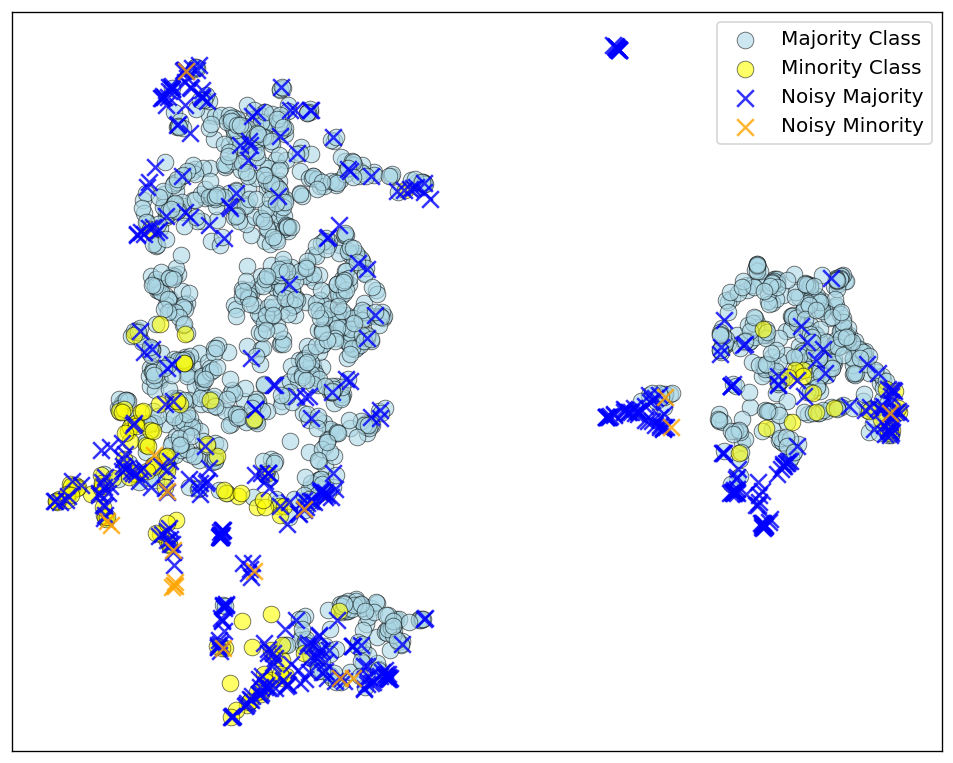

C:\Users\Жибек\AppData\Local\Temp\ipykernel_16736\3145940431.py:307: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_marks['total'] = combined_marks.sum(axis=1)
C:\conda\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


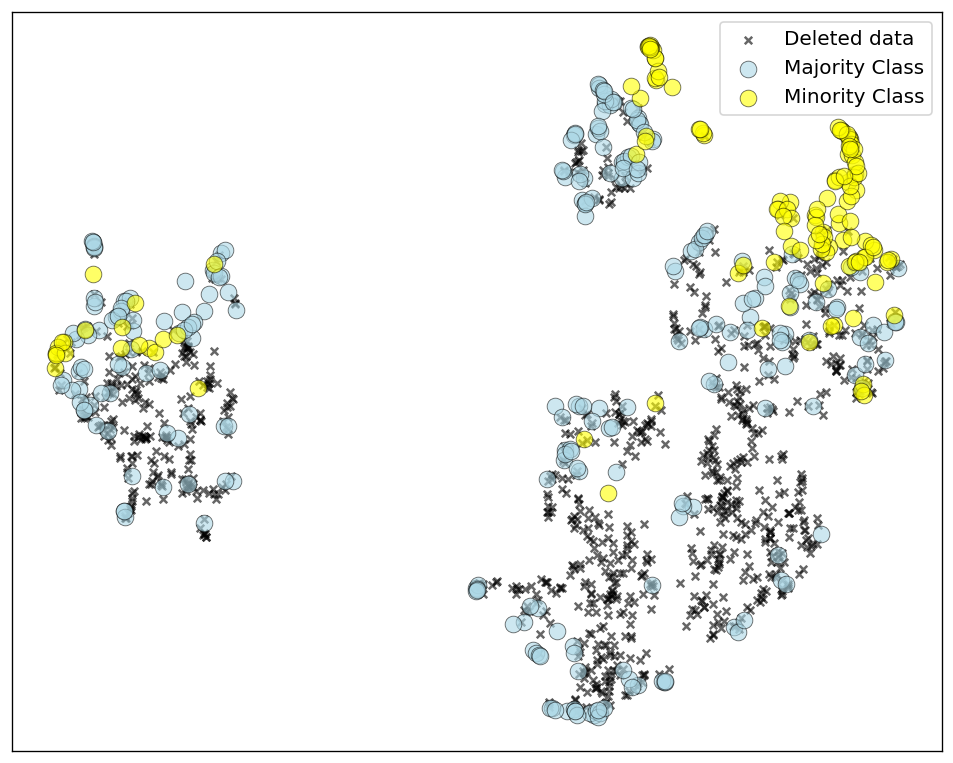

In [13]:
features = df.columns.drop("target")
processor = DataProcessor(df, class_col="target", feature_cols=features)

# Step 1: Calculate posterior probabilities
processor.calculate_posterior_probabilities()

# Step 2: Apply TACF for noise removal
processor.compute_tacf(threshold_type='std', threshold_value=3, min_features=2)
processor.visualize(title="UMAP Projection After Noise Removal",mode ='noise')
# Step 3: Undersample the majority class
result = processor.undersample(maj_class=0, gamma=1.0, ratio=0.5)

# Step 4: Visualize the results
processor.visualize(title="UMAP Projection After Undersampling", mode='undersampling')

In [14]:
# Removal of Redundant Features Generated During Computation
result = result.iloc[:,:-3]
df=df.iloc[:,:-3]
result

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,target
11,0.02,0.46,0.08,0.91,0.07,0.10,0.34,0.36,0.22,0.57,...,0.20,0.88,0.91,0.90,0.93,0.01,0.63,1.00,0.00,0
14,0.04,0.36,0.01,0.85,0.14,0.26,0.32,0.46,0.30,0.31,...,0.40,0.42,0.31,0.51,0.53,0.02,0.40,0.15,0.00,0
28,0.01,0.27,0.43,0.64,0.08,0.01,0.36,0.33,0.22,0.74,...,0.05,0.82,0.68,0.79,0.78,0.02,0.17,0.00,0.00,0
30,0.01,0.30,0.00,0.99,0.02,0.01,0.38,0.37,0.27,0.74,...,0.00,0.82,0.54,0.72,0.76,0.04,0.07,0.01,0.00,0
40,0.01,0.46,0.01,0.98,0.03,0.04,0.31,0.38,0.20,0.59,...,0.10,0.60,0.52,0.56,0.76,0.14,0.02,0.10,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1865,0.25,0.36,0.52,0.52,0.09,0.16,0.49,0.69,0.51,0.35,...,0.20,0.27,0.27,0.34,0.19,0.19,0.20,0.20,0.96,1
1878,0.10,0.56,0.12,0.47,0.12,0.77,0.47,0.57,0.36,0.39,...,0.62,0.56,0.44,0.64,0.49,0.02,0.84,0.15,0.93,1
1910,0.20,0.94,0.28,0.34,0.41,0.95,0.51,0.64,0.43,0.19,...,0.94,0.43,0.34,0.67,0.66,0.06,0.48,0.18,0.42,1
1957,0.27,0.32,0.66,0.46,0.05,0.01,0.39,0.51,0.32,0.39,...,0.06,0.73,0.49,0.70,0.70,0.30,0.14,0.08,0.41,1


In [15]:
# Class Ratio in the Final Dataset
result['target'].value_counts()

target
0    264
1    132
Name: count, dtype: int64

### Model Training

In [16]:
# Random forest on original data
rndf_weights(df,13,42,38,'original',2)

Training set:
target
0    1831
1     137
Name: count, dtype: int64

Test set:
target
0    13
1    13
Name: count, dtype: int64
Fold 1 - Accuracy: 0.9106, AUC: 0.9307, Precision: 0.3889, Recall: 0.5147
Fold 2 - Accuracy: 0.9004, AUC: 0.9161, Precision: 0.3739, Recall: 0.6232

Test Data Evaluation - Accuracy: 0.7692, AUC: 0.8491, Precision: 0.8182, Recall: 0.6923


(0.7692307692307693, 0.849112426035503, 0.8181818181818182, 0.6923076923076923)

In [17]:
# Random forest on undersampled data
rndf_weights(result,13,42,38,'undersampled',2)

Training set:
target
0    251
1    119
Name: count, dtype: int64

Test set:
target
0    13
1    13
Name: count, dtype: int64
Fold 1 - Accuracy: 0.9135, AUC: 0.9631, Precision: 0.8909, Recall: 0.8305
Fold 2 - Accuracy: 0.8270, AUC: 0.9108, Precision: 0.8043, Recall: 0.6167

Test Data Evaluation - Accuracy: 0.9231, AUC: 0.9349, Precision: 0.9231, Recall: 0.9231


(0.9230769230769231,
 0.9349112426035503,
 0.9230769230769231,
 0.9230769230769231)

In [18]:
# LightGBM on original data
lgbm_weights(df,13,10,23,'original',2)

Training set:
target
0    1831
1     137
Name: count, dtype: int64

Test set:
target
0    13
1    13
Name: count, dtype: int64
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.105705	valid_1's binary_logloss: 0.186713
[20]	training's binary_logloss: 0.065652	valid_1's binary_logloss: 0.182058
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.0673843	valid_1's binary_logloss: 0.181675
Fold 1 - Accuracy: 0.9268, AUC: 0.8960, Precision: 0.4750, Recall: 0.5588
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.099614	valid_1's binary_logloss: 0.17648
[20]	training's binary_logloss: 0.0613804	valid_1's binary_logloss: 0.168154
[30]	training's binary_logloss: 0.0330728	valid_1's binary_logloss: 0.165238
[40]	training's binary_logloss: 0.0180849	valid_1's binary_logloss: 0.170441
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.0271214	valid_1's binary_logloss: 0.16

In [19]:
# LightGBM on undersampled data
lgbm_weights(result,13,10,23,'undersampled',2)

Training set:
target
0    251
1    119
Name: count, dtype: int64

Test set:
target
0    13
1    13
Name: count, dtype: int64
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.29695	valid_1's binary_logloss: 0.371819
[20]	training's binary_logloss: 0.161648	valid_1's binary_logloss: 0.311724
[30]	training's binary_logloss: 0.0949081	valid_1's binary_logloss: 0.304155
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.105069	valid_1's binary_logloss: 0.299057
Fold 1 - Accuracy: 0.8703, AUC: 0.9235, Precision: 0.8723, Recall: 0.6949
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.307992	valid_1's binary_logloss: 0.358449
[20]	training's binary_logloss: 0.180961	valid_1's binary_logloss: 0.295342
[30]	training's binary_logloss: 0.112471	valid_1's binary_logloss: 0.260196
[40]	training's binary_logloss: 0.0703875	valid_1's binary_logloss: 0.253955
Early stopping, best iteration is:


In [20]:
# MLP on undersampled data
mlp_weight(result,13,18,42)

Training set:
target
0    251
1    119
Name: count, dtype: int64

Test set:
target
0    13
1    13
Name: count, dtype: int64
Fold 1 - Accuracy: 0.8811, AUC: 0.9397, Precision: 0.7937, Recall: 0.8475
Fold 2 - Accuracy: 0.8703, AUC: 0.9400, Precision: 0.9286, Recall: 0.6500

Test Data Evaluation - Accuracy: 0.9615, AUC: 0.9941, Precision: 1.0000, Recall: 0.9231


(0.9615384615384616, 0.9940828402366865, 1.0, 0.9230769230769231)

In [21]:
# MLP on original data
mlp_weight(df,13,18,42)

Training set:
target
0    1831
1     137
Name: count, dtype: int64

Test set:
target
0    13
1    13
Name: count, dtype: int64
Fold 1 - Accuracy: 0.9400, AUC: 0.9180, Precision: 0.5957, Recall: 0.4118
Fold 2 - Accuracy: 0.9461, AUC: 0.9183, Precision: 0.7353, Recall: 0.3623

Test Data Evaluation - Accuracy: 0.6538, AUC: 0.9112, Precision: 1.0000, Recall: 0.3077


(0.6538461538461539, 0.9112426035502958, 1.0, 0.3076923076923077)

## Results Using the Same Parameters on Alternative Algorithms

### SMOTE

In [22]:
#SMOTE
from collections import Counter
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(df.iloc[:,:-1], df.iloc[:,-1])
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 1844, 1: 1844})


In [23]:
data_new_smote = X_res
data_new_smote['target']=y_res
data_new_smote

C:\Users\Жибек\AppData\Local\Temp\ipykernel_16736\798921481.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_new_smote['target']=y_res


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,target
0,0.190000,0.330000,0.020000,0.900000,0.120000,0.170000,0.340000,0.470000,0.290000,0.320000,...,0.120000,0.420000,0.500000,0.510000,0.640000,0.120000,0.260000,0.200000,0.320000,0
1,0.000000,0.160000,0.120000,0.740000,0.450000,0.070000,0.260000,0.590000,0.350000,0.270000,...,0.210000,0.500000,0.340000,0.600000,0.520000,0.020000,0.120000,0.450000,0.000000,1
2,0.000000,0.420000,0.490000,0.560000,0.170000,0.040000,0.390000,0.470000,0.280000,0.320000,...,0.140000,0.490000,0.540000,0.670000,0.560000,0.010000,0.210000,0.020000,0.000000,0
3,0.040000,0.770000,1.000000,0.080000,0.120000,0.100000,0.510000,0.500000,0.340000,0.210000,...,0.190000,0.300000,0.730000,0.640000,0.650000,0.020000,0.390000,0.280000,0.000000,0
4,0.010000,0.550000,0.020000,0.950000,0.090000,0.050000,0.380000,0.380000,0.230000,0.360000,...,0.110000,0.720000,0.640000,0.610000,0.530000,0.040000,0.090000,0.020000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3683,0.088628,0.447059,0.305494,0.358820,0.641569,0.500393,0.377255,0.591766,0.374510,0.283921,...,0.693728,0.432548,0.338431,0.740000,0.629803,0.015686,0.914707,0.204707,0.202749,1
3684,0.022808,0.427533,0.709449,0.419318,0.068766,0.008425,0.464383,0.510341,0.340000,0.438976,...,0.042808,0.811575,0.561916,0.743150,0.744383,0.113150,0.056850,0.048084,0.000000,1
3685,0.016900,0.455633,0.954934,0.152098,0.021266,0.005633,0.435633,0.449433,0.292533,0.513668,...,0.026900,0.851135,0.639301,0.806768,0.758034,0.026900,0.226768,0.104934,0.000000,1
3686,0.047175,0.372900,0.732975,0.418475,0.025725,0.010000,0.478625,0.508625,0.382900,0.562675,...,0.014275,0.805725,0.492825,0.709925,0.750000,0.081525,0.134200,0.072900,0.000000,1


In [24]:
#SMOTE
rndf_overs1(data_new_smote,len(data_new_smote)-len(df),13,42,38)

Training set:
target
0    1831
1     137
Name: count, dtype: int64

Test set:
target
0    13
1    13
Name: count, dtype: int64
Fold 1 - Accuracy: 0.9153, AUC: 0.9760, Precision: 0.8934, Recall: 0.9432
Fold 2 - Accuracy: 0.9110, AUC: 0.9746, Precision: 0.8815, Recall: 0.9498

Test Data Evaluation - Accuracy: 0.8462, AUC: 0.9349, Precision: 0.8462, Recall: 0.8462


(0.8461538461538461,
 0.9349112426035503,
 0.8461538461538461,
 0.8461538461538461)

In [25]:
#SMOTE
lgbm_overs1(data_new_smote,len(data_new_smote)-len(df),13,10,23)

Training set:
target
0    1831
1     137
Name: count, dtype: int64

Test set:
target
0    13
1    13
Name: count, dtype: int64
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.273402	valid_1's binary_logloss: 0.330965
[20]	training's binary_logloss: 0.133842	valid_1's binary_logloss: 0.215659
[30]	training's binary_logloss: 0.0677986	valid_1's binary_logloss: 0.162468
[40]	training's binary_logloss: 0.0342001	valid_1's binary_logloss: 0.137572
[50]	training's binary_logloss: 0.017548	valid_1's binary_logloss: 0.124628
[60]	training's binary_logloss: 0.0092042	valid_1's binary_logloss: 0.119792
[70]	training's binary_logloss: 0.00479761	valid_1's binary_logloss: 0.116769
[80]	training's binary_logloss: 0.00252091	valid_1's binary_logloss: 0.115699
Early stopping, best iteration is:
[77]	training's binary_logloss: 0.00304783	valid_1's binary_logloss: 0.115332
Fold 1 - Accuracy: 0.9623, AUC: 0.9916, Precision: 0.9415, Recall: 0.9858
Training u

(0.9615384615384616, 1.0, 0.9285714285714286, 1.0)

In [26]:
#SMOTE
mlp_overs1(data_new_smote,len(data_new_smote)-len(df),13,18,42)

Training set:
target
0    1831
1     137
Name: count, dtype: int64

Test set:
target
0    13
1    13
Name: count, dtype: int64
Fold 1 - Accuracy: 0.9093, AUC: 0.9621, Precision: 0.8682, Recall: 0.9650
Fold 2 - Accuracy: 0.9345, AUC: 0.9758, Precision: 0.9289, Recall: 0.9410

Test Data Evaluation - Accuracy: 0.8846, AUC: 0.9586, Precision: 0.9167, Recall: 0.8462


(0.8846153846153846,
 0.9585798816568047,
 0.9166666666666666,
 0.8461538461538461)

### ADASYN

In [27]:
#Adasyn
from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=42)
X_res, y_res = ada.fit_resample(df.iloc[:,:-1], df.iloc[:,-1])
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 1844, 1: 1829})


In [28]:
data_new_ada = X_res
data_new_ada['target']=y_res
data_new_ada

C:\Users\Жибек\AppData\Local\Temp\ipykernel_16736\3559623243.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_new_ada['target']=y_res


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,target
0,0.190000,0.330000,0.020000,0.900000,0.120000,0.170000,0.340000,0.470000,0.290000,0.320000,...,0.120000,0.420000,0.500000,0.510000,0.640000,0.120000,0.260000,0.200000,0.320000,0
1,0.000000,0.160000,0.120000,0.740000,0.450000,0.070000,0.260000,0.590000,0.350000,0.270000,...,0.210000,0.500000,0.340000,0.600000,0.520000,0.020000,0.120000,0.450000,0.000000,1
2,0.000000,0.420000,0.490000,0.560000,0.170000,0.040000,0.390000,0.470000,0.280000,0.320000,...,0.140000,0.490000,0.540000,0.670000,0.560000,0.010000,0.210000,0.020000,0.000000,0
3,0.040000,0.770000,1.000000,0.080000,0.120000,0.100000,0.510000,0.500000,0.340000,0.210000,...,0.190000,0.300000,0.730000,0.640000,0.650000,0.020000,0.390000,0.280000,0.000000,0
4,0.010000,0.550000,0.020000,0.950000,0.090000,0.050000,0.380000,0.380000,0.230000,0.360000,...,0.110000,0.720000,0.640000,0.610000,0.530000,0.040000,0.090000,0.020000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3668,0.440314,0.330543,0.489095,0.561448,0.079638,0.275295,0.370181,0.500362,0.329638,0.468010,...,0.226743,0.425428,0.479819,0.641628,0.553438,0.332304,0.209276,0.180000,0.508733,1
3669,0.974880,0.410239,0.791676,0.326003,0.053720,0.013720,0.423960,0.526280,0.341400,0.378840,...,0.043720,0.676040,0.539079,0.792799,0.721160,0.843002,0.188840,0.230239,0.722597,1
3670,0.918322,0.332077,0.224851,0.307326,0.957923,0.304552,0.282077,0.502176,0.309701,0.427824,...,0.930697,0.317326,0.447824,0.562276,0.519900,0.132475,0.930697,0.839118,0.588023,1
3671,1.000000,0.332332,0.219769,0.288372,0.934874,0.338151,0.270935,0.491166,0.301166,0.433950,...,1.000000,0.301628,0.475116,0.569307,0.519769,0.271649,0.938130,0.936502,0.617206,1


In [29]:
#Adasyn
rndf_overs1(data_new_ada,len(data_new_ada)-len(df),13,42,38)

Training set:
target
0    1831
1     137
Name: count, dtype: int64

Test set:
target
0    13
1    13
Name: count, dtype: int64
Fold 1 - Accuracy: 0.9227, AUC: 0.9715, Precision: 0.8893, Recall: 0.9648
Fold 2 - Accuracy: 0.8969, AUC: 0.9704, Precision: 0.8689, Recall: 0.9339

Test Data Evaluation - Accuracy: 0.8462, AUC: 0.9349, Precision: 0.8462, Recall: 0.8462


(0.8461538461538461,
 0.9349112426035504,
 0.8461538461538461,
 0.8461538461538461)

In [30]:
#Adasyn
lgbm_overs1(data_new_ada,len(data_new_ada)-len(df),13,10,23)

Training set:
target
0    1831
1     137
Name: count, dtype: int64

Test set:
target
0    13
1    13
Name: count, dtype: int64
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.29002	valid_1's binary_logloss: 0.34423
[20]	training's binary_logloss: 0.143728	valid_1's binary_logloss: 0.22416
[30]	training's binary_logloss: 0.0723737	valid_1's binary_logloss: 0.165394
[40]	training's binary_logloss: 0.0370212	valid_1's binary_logloss: 0.133848
[50]	training's binary_logloss: 0.0189639	valid_1's binary_logloss: 0.119463
[60]	training's binary_logloss: 0.0100166	valid_1's binary_logloss: 0.11521
[70]	training's binary_logloss: 0.00534205	valid_1's binary_logloss: 0.114527
Early stopping, best iteration is:
[68]	training's binary_logloss: 0.00604817	valid_1's binary_logloss: 0.113348
Fold 1 - Accuracy: 0.9616, AUC: 0.9916, Precision: 0.9411, Recall: 0.9846
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss

(0.9230769230769231, 0.9940828402366865, 1.0, 0.8461538461538461)

In [31]:
#ADASYN
mlp_overs1(data_new_ada,len(data_new_ada)-len(df),13,18,42)

Training set:
target
0    1831
1     137
Name: count, dtype: int64

Test set:
target
0    13
1    13
Name: count, dtype: int64
Fold 1 - Accuracy: 0.9221, AUC: 0.9664, Precision: 0.8770, Recall: 0.9813
Fold 2 - Accuracy: 0.9413, AUC: 0.9745, Precision: 0.9116, Recall: 0.9769

Test Data Evaluation - Accuracy: 0.8846, AUC: 0.9645, Precision: 0.9167, Recall: 0.8462


(0.8846153846153846,
 0.9644970414201184,
 0.9166666666666666,
 0.8461538461538461)

### LoRAS

In [32]:
import pandas as pd
from collections import Counter
from pyloras import LORAS
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Применяем LoRAS
loras = LORAS(n_neighbors=5, random_state=42)
X_res, y_res = loras.fit_resample(X, y)

print('Исходное распределение классов:', Counter(y))
print('После применения LoRAS:', Counter(y_res))
# Преобразуем X_res в DataFrame
data_new_loras = pd.DataFrame(X_res, columns=df.columns[:-1])

# Добавим столбец с метками
data_new_loras['target'] = y_res

# Показываем результат
data_new_loras.head()

Исходное распределение классов: Counter({0: 1844, 1: 150})
После применения LoRAS: Counter({0: 1844, 1: 1844})


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,target
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,1
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0


In [33]:
#Loras
rndf_overs1(data_new_loras,len(data_new_loras)-len(df),13,42,38)

Training set:
target
0    1831
1     137
Name: count, dtype: int64

Test set:
target
0    13
1    13
Name: count, dtype: int64
Fold 1 - Accuracy: 0.9525, AUC: 0.9927, Precision: 0.9433, Recall: 0.9628
Fold 2 - Accuracy: 0.9541, AUC: 0.9927, Precision: 0.9407, Recall: 0.9694

Test Data Evaluation - Accuracy: 0.7692, AUC: 0.8787, Precision: 0.8889, Recall: 0.6154


(0.7692307692307693, 0.878698224852071, 0.8888888888888888, 0.6153846153846154)

In [34]:
#Loras
lgbm_overs1(data_new_loras,len(data_new_loras)-len(df),13,10,23)

Training set:
target
0    1831
1     137
Name: count, dtype: int64

Test set:
target
0    13
1    13
Name: count, dtype: int64
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.242841	valid_1's binary_logloss: 0.270196
[20]	training's binary_logloss: 0.106586	valid_1's binary_logloss: 0.155093
[30]	training's binary_logloss: 0.0507764	valid_1's binary_logloss: 0.115005
[40]	training's binary_logloss: 0.0238931	valid_1's binary_logloss: 0.10522
[50]	training's binary_logloss: 0.0116293	valid_1's binary_logloss: 0.103181
[60]	training's binary_logloss: 0.00563066	valid_1's binary_logloss: 0.106696
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.0101547	valid_1's binary_logloss: 0.102642
Fold 1 - Accuracy: 0.9640, AUC: 0.9935, Precision: 0.9680, Recall: 0.9596
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.244408	valid_1's binary_logloss: 0.263287
[20]	training's binary_loglos

(0.6923076923076923, 0.9644970414201184, 1.0, 0.38461538461538464)

In [35]:
#Loras
mlp_overs1(data_new_loras,len(data_new_loras)-len(df),13,18,42)

Training set:
target
0    1831
1     137
Name: count, dtype: int64

Test set:
target
0    13
1    13
Name: count, dtype: int64
Fold 1 - Accuracy: 0.9514, AUC: 0.9796, Precision: 0.9275, Recall: 0.9792
Fold 2 - Accuracy: 0.9689, AUC: 0.9861, Precision: 0.9564, Recall: 0.9825

Test Data Evaluation - Accuracy: 0.7308, AUC: 0.9349, Precision: 0.8750, Recall: 0.5385


(0.7307692307692307, 0.9349112426035503, 0.875, 0.5384615384615384)

### Random Undersampling

In [36]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(df.iloc[:,:-1], df.iloc[:,-1])
data_new = X_resampled
data_new['target']=y_resampled
rndf_weights(data_new,13,42,38,'undersampled',2)

Training set:
target
0    137
1    137
Name: count, dtype: int64

Test set:
target
0    13
1    13
Name: count, dtype: int64


C:\Users\Жибек\AppData\Local\Temp\ipykernel_16736\3791463109.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_new['target']=y_resampled


Fold 1 - Accuracy: 0.8248, AUC: 0.9233, Precision: 0.8056, Recall: 0.8529
Fold 2 - Accuracy: 0.8467, AUC: 0.9373, Precision: 0.8333, Recall: 0.8696

Test Data Evaluation - Accuracy: 0.8846, AUC: 0.9112, Precision: 0.9167, Recall: 0.8462


(0.8846153846153846,
 0.9112426035502958,
 0.9166666666666666,
 0.8461538461538461)

In [37]:
lgbm_weights(data_new,13,10,23,'undersampled',2)

Training set:
target
0    137
1    137
Name: count, dtype: int64

Test set:
target
0    13
1    13
Name: count, dtype: int64
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.331431	valid_1's binary_logloss: 0.430075
[20]	training's binary_logloss: 0.199103	valid_1's binary_logloss: 0.378404
[30]	training's binary_logloss: 0.129243	valid_1's binary_logloss: 0.381717
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.1738	valid_1's binary_logloss: 0.376471
Fold 1 - Accuracy: 0.8832, AUC: 0.9174, Precision: 0.8824, Recall: 0.8824
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.346577	valid_1's binary_logloss: 0.422744
[20]	training's binary_logloss: 0.213482	valid_1's binary_logloss: 0.378867
[30]	training's binary_logloss: 0.138546	valid_1's binary_logloss: 0.381907
Early stopping, best iteration is:
[25]	training's binary_logloss: 0.169555	valid_1's binary_logloss: 0.370698
Fol

In [38]:
mlp_weight(data_new,13,18,42)

Training set:
target
0    137
1    137
Name: count, dtype: int64

Test set:
target
0    13
1    13
Name: count, dtype: int64
Fold 1 - Accuracy: 0.9270, AUC: 0.9699, Precision: 0.9394, Recall: 0.9118
Fold 2 - Accuracy: 0.8175, AUC: 0.9017, Precision: 0.7821, Recall: 0.8841

Test Data Evaluation - Accuracy: 0.9615, AUC: 0.9527, Precision: 1.0000, Recall: 0.9231


(0.9615384615384616, 0.9526627218934911, 1.0, 0.9230769230769231)

### One Sided Selection

In [39]:
from imblearn.under_sampling import OneSidedSelection
oss = OneSidedSelection(random_state=0)
X_resampled, y_resampled = oss.fit_resample(df.iloc[:,:-1], df.iloc[:,-1])
data_new = X_resampled
data_new['target']=y_resampled
rndf_weights(data_new,13,42,38,'undersampled',2)

C:\Users\Жибек\AppData\Local\Temp\ipykernel_16736\2003178298.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_new['target']=y_resampled


Training set:
target
0    1373
1     137
Name: count, dtype: int64

Test set:
target
0    13
1    13
Name: count, dtype: int64
Fold 1 - Accuracy: 0.9285, AUC: 0.9369, Precision: 0.9375, Recall: 0.2206
Fold 2 - Accuracy: 0.9232, AUC: 0.8824, Precision: 0.6897, Recall: 0.2899

Test Data Evaluation - Accuracy: 0.6154, AUC: 0.9112, Precision: 1.0000, Recall: 0.2308


(0.6153846153846154, 0.911242603550296, 1.0, 0.23076923076923078)

In [40]:
lgbm_weights(data_new,13,10,23,'undersampled',2)

Training set:
target
0    1373
1     137
Name: count, dtype: int64

Test set:
target
0    13
1    13
Name: count, dtype: int64
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.135495	valid_1's binary_logloss: 0.219239
[20]	training's binary_logloss: 0.0780052	valid_1's binary_logloss: 0.204954
[30]	training's binary_logloss: 0.0442918	valid_1's binary_logloss: 0.201683
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.049511	valid_1's binary_logloss: 0.200144
Fold 1 - Accuracy: 0.9232, AUC: 0.8850, Precision: 0.6250, Recall: 0.3676
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.127253	valid_1's binary_logloss: 0.212903
[20]	training's binary_logloss: 0.0708506	valid_1's binary_logloss: 0.206529
[30]	training's binary_logloss: 0.0400982	valid_1's binary_logloss: 0.208399
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.0420146	valid_1's binary_logloss: 0.2

In [41]:
mlp_weight(data_new,13,18,42)

Training set:
target
0    1373
1     137
Name: count, dtype: int64

Test set:
target
0    13
1    13
Name: count, dtype: int64
Fold 1 - Accuracy: 0.9364, AUC: 0.9277, Precision: 0.6923, Recall: 0.5294
Fold 2 - Accuracy: 0.9285, AUC: 0.8980, Precision: 0.6829, Recall: 0.4058

Test Data Evaluation - Accuracy: 0.5769, AUC: 0.7811, Precision: 0.6667, Recall: 0.3077


(0.5769230769230769,
 0.7810650887573966,
 0.6666666666666666,
 0.3076923076923077)

### Tomek Links

In [42]:
from imblearn.under_sampling import TomekLinks
tl = TomekLinks()
X_res, y_res = tl.fit_resample(df.iloc[:,:-1], df.iloc[:,-1])
data_new = X_res
data_new['target']=y_res
rndf_weights(data_new,13,42,38,'undersampled',2)

C:\Users\Жибек\AppData\Local\Temp\ipykernel_16736\3608048443.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_new['target']=y_res


Training set:
target
0    1805
1     137
Name: count, dtype: int64

Test set:
target
0    13
1    13
Name: count, dtype: int64
Fold 1 - Accuracy: 0.9413, AUC: 0.9466, Precision: 0.7619, Recall: 0.2353
Fold 2 - Accuracy: 0.9423, AUC: 0.9086, Precision: 0.6857, Recall: 0.3478

Test Data Evaluation - Accuracy: 0.6538, AUC: 0.8047, Precision: 1.0000, Recall: 0.3077


(0.6538461538461539, 0.8047337278106509, 1.0, 0.3076923076923077)

In [43]:
lgbm_weights(data_new,13,10,23,'undersampled',2)

Training set:
target
0    1805
1     137
Name: count, dtype: int64

Test set:
target
0    13
1    13
Name: count, dtype: int64
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.106544	valid_1's binary_logloss: 0.163915
[20]	training's binary_logloss: 0.0569204	valid_1's binary_logloss: 0.153803
[30]	training's binary_logloss: 0.0308462	valid_1's binary_logloss: 0.154816
Early stopping, best iteration is:
[25]	training's binary_logloss: 0.0420856	valid_1's binary_logloss: 0.151773
Fold 1 - Accuracy: 0.9403, AUC: 0.9297, Precision: 0.6136, Recall: 0.3971
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.103739	valid_1's binary_logloss: 0.16545
[20]	training's binary_logloss: 0.0546771	valid_1's binary_logloss: 0.154976
[30]	training's binary_logloss: 0.0292136	valid_1's binary_logloss: 0.153831
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.0347955	valid_1's binary_logloss: 0.1

In [44]:
mlp_weight(data_new,13,18,42)

Training set:
target
0    1805
1     137
Name: count, dtype: int64

Test set:
target
0    13
1    13
Name: count, dtype: int64
Fold 1 - Accuracy: 0.9434, AUC: 0.9085, Precision: 0.6275, Recall: 0.4706
Fold 2 - Accuracy: 0.9351, AUC: 0.9445, Precision: 0.5625, Recall: 0.3913

Test Data Evaluation - Accuracy: 0.7308, AUC: 0.8817, Precision: 1.0000, Recall: 0.4615


(0.7307692307692307, 0.8816568047337279, 1.0, 0.46153846153846156)